# Project: ML - KNN, Multivariate Liner Regression and Random Forest Regressor (Predicting Car Prices)

<br>

## Questions to address:
- Predict car prices using a KNN ML algorithm
- For each car we have information about the technical aspects of the vehicle such as the motor's displacement, the weight of the car, the miles per gallon, how fast the car accelerates, and more.

<br>

## Tools:
- KNN model
  - algorithm = auto
  - p = 2 (euclidean distance)
  - rmse as metric
- Feature Preparation, Selection and Engineering
  - transforming and processing: 
    - identify numeric columns
    - replace '?' with Nan
    - convert some to float
    - drop cols with NaN in target column
    - replace NaNs with mean from other rows
    - normalize features
  - selection: 
    - one feature at a time
    - different combinations of the best individual features
  - RFECV feature selection (10 folds)
- Hyperparameter Optimization (on the k_neighbours value of the KNN algorithm)
- K-fold Validation
- K-fold predict

<br>

### load defaults

In [45]:
import numpy as np
import pandas as pd
import seaborn as sns
import re
import requests 

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from matplotlib import rcParams
import matplotlib.dates as mdates
from datetime import datetime
from IPython.display import display, Math

from functions import *

plt.rcParams.update({'axes.titlepad': 20, 'font.size': 12, 'axes.titlesize':20})

colors = [(0/255,107/255,164/255), (255/255, 128/255, 14/255), 'red', 'green', '#9E80BA', '#8EDB8E', '#58517A']
Ncolors = 10
color_map = plt.cm.Blues_r(np.linspace(0.2, 0.5, Ncolors))
#color_map = plt.cm.tab20c_r(np.linspace(0.2, 0.5, Ncolors))


#specific to this project
from sklearn.feature_selection import RFECV

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, KFold, cross_val_predict


print("Defaults Loaded")

Defaults Loaded


<br>

## Dataset: Car properties and price

In [3]:
cols = ['symboling', 'normalized-losses', 'make', 'fuel-type', 'aspiration', 'num-of-doors', 'body-style', 
        'drive-wheels', 'engine-location', 'wheel-base', 'length', 'width', 'height', 'curb-weight', 
        'engine-type', 'num-of-cylinders', 'engine-size', 'fuel-system', 'bore', 'stroke', 'compression-rate', 
        'horsepower', 'peak-rpm', 'city-mpg', 'highway-mpg', 'price']
cars = pd.read_csv("./data/imports-85.data", names=cols)

display(cars.iloc[:3,:14])

,symboling,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,length,width,height,curb-weight
0,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548
1,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548
2,1,?,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,171.2,65.5,52.4,2823


<br>

## Analysis:

<br>

## 1 - Feature Preparation, Selection and Engineering

### transforming and processing
- identify numeric columns
- replace '?' with Nan
- convert to float
- drop cols with NaN in target column
- replace NaNs with mean from other rows
- normalize features

In [14]:
continuous_values_cols = ['normalized-losses', 'wheel-base', 'length', 'width', 'height', 
                          'curb-weight', 'engine-size', 'bore', 'stroke', 'compression-rate', 'horsepower', 
                          'peak-rpm', 'city-mpg', 'highway-mpg', 'price']

numeric_cars = cars[continuous_values_cols].copy()

#replace ? with nan 
numeric_cars.replace('?', np.nan, inplace=True)

#convert some columns to float
to_convert = ['normalized-losses','bore','stroke','horsepower', 'peak-rpm','price']
numeric_cars[to_convert] = numeric_cars[to_convert].astype(float)

#drop cols with Nan price
numeric_cars = numeric_cars.dropna(subset=['price'])

#replace NaN with mean from other rows
numeric_cars = numeric_cars.fillna(numeric_cars.mean())

#normalize features
price = numeric_cars['price']
#normalized_cars = (numeric_cars - numeric_cars.mean()) / (numeric_cars.std())
numeric_cars = (numeric_cars - numeric_cars.min())/(numeric_cars.max() - numeric_cars.min())
numeric_cars['price'] = price

display(numeric_cars.iloc[:3,:13])

,normalized-losses,wheel-base,length,width,height,curb-weight,engine-size,bore,stroke,compression-rate,horsepower,peak-rpm,city-mpg
0,0.298429,0.058309,0.413433,0.324786,0.083333,0.411171,0.260377,0.664286,0.290476,0.125,0.294393,0.346939,0.222222
1,0.298429,0.058309,0.413433,0.324786,0.083333,0.411171,0.260377,0.664286,0.290476,0.125,0.294393,0.346939,0.222222
2,0.298429,0.230321,0.449254,0.444444,0.383333,0.517843,0.343396,0.100000,0.666667,0.125,0.495327,0.346939,0.166667


**randomize rows so the neighbours found are not biased**

In [17]:
np.random.seed(1)    
numeric_cars = numeric_cars.iloc[np.random.permutation(len(numeric_cars))]
display(numeric_cars.iloc[:3,:13])  

,normalized-losses,wheel-base,length,width,height,curb-weight,engine-size,bore,stroke,compression-rate,horsepower,peak-rpm,city-mpg
100,0.214660,0.309038,0.482090,0.418803,0.575000,0.315749,0.222642,0.564286,0.666667,0.09375,0.228972,0.428571,0.388889
120,0.465969,0.206997,0.241791,0.299145,0.233333,0.185803,0.109434,0.307143,0.552381,0.15000,0.093458,0.551020,0.500000
62,0.261780,0.355685,0.547761,0.529915,0.641667,0.357642,0.230189,0.607143,0.628571,0.10000,0.168224,0.265306,0.361111


<br>

### feature selection
- first one at a time (univariate), then, different combinations of the best individual features
- model: KNN
- k value = 5
- train/test validation
- rmse as metric

**One feature at a time: univariate KNN**

In [6]:
def knn_train_test(feature, target, df):    
    train = df[0:int(len(df)/2)]
    test = df[int(len(df)/2):]
    
    knn = KNeighborsRegressor(n_neighbors = 5, algorithm = 'auto', p=2)
    knn.fit(train[[feature]], train[target])
    predictions = knn.predict(test[[feature]])
    rmse = np.sqrt(np.absolute(mean_squared_error(test[target], predictions)))
    return rmse

features = continuous_values_cols[:]
features.remove('price')

rmse_dict = {}
for element in features:
    rmse = knn_train_test(element, ['price'], numeric_cars)
    rmse_dict[element] = rmse
    
rmse_results_series = pd.Series(rmse_dict)
sorted_features = rmse_results_series.sort_values().index.tolist()

print("Feature Name    |    RMSE Value")
print(rmse_results_series.sort_values())

Feature Name    |    RMSE Value
engine-size          3238.462830
horsepower           4037.037713
curb-weight          4401.118255
highway-mpg          4630.026799
width                4704.482590
city-mpg             4766.422505
length               5427.200961
wheel-base           5461.553998
compression-rate     6610.812153
bore                 6780.627785
normalized-losses    7330.197653
peak-rpm             7697.459696
stroke               8006.529545
height               8144.441043
dtype: float64


**Try different combinations of the 5 best individual features**

In [7]:
#modify the knn_train_test() function we wrote in the last step to work with multiple columns.
import numpy as np
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
%matplotlib inline

def knn_train_test(feature, target, k_value, df):   
    train = df[0:int(len(df)/2)]
    test = df[int(len(df)/2):]
    
    knn = KNeighborsRegressor(n_neighbors = k_value, algorithm = 'auto', p=2)
    knn.fit(train[feature], train[target])
    predictions = knn.predict(test[feature])
    rmse = np.sqrt(np.absolute(mean_squared_error(test[target], predictions)))
    return rmse

k_value = 5

#run the model
features = ['engine-size', 'horsepower']
rmse = knn_train_test(features, ['price'], k_value, numeric_cars)
print("RMSE: {:0.2f} (engine-size + horsepower)".format(rmse))
features = ['engine-size', 'horsepower', 'curb-weight']
rmse = knn_train_test(features, ['price'], k_value, numeric_cars)
print("RMSE: {:0.2f} (engine-size + horsepower + curb-weight)".format(rmse)) 
features = ['engine-size', 'horsepower', 'curb-weight', 'highway-mpg']
rmse = knn_train_test(features, ['price'], k_value, numeric_cars)
print("RMSE: {:0.2f} (engine-size + horsepower + curb-weight + highway-mpg)".format(rmse)) 
features = ['engine-size', 'horsepower', 'curb-weight', 'highway-mpg', 'width']
rmse = knn_train_test(features, ['price'], k_value, numeric_cars)
print("RMSE: {:0.2f} (engine-size + horsepower + curb-weight + highway-mpg + width)".format(rmse)) 

RMSE: 2949.88 (engine-size + horsepower)
RMSE: 3435.26 (engine-size + horsepower + curb-weight)
RMSE: 3286.56 (engine-size + horsepower + curb-weight + highway-mpg)
RMSE: 3410.22 (engine-size + horsepower + curb-weight + highway-mpg + width)


<br>

## 2 - Hyperparameter Optimization (of the k-value)
- for each individual feature and k-value 1 to 15
- For the top 3 models in the last step and k-value 1 to 15 
- with holdout validation

KNN function that takes in some feature(s), a target, some k_value (n_neighbours in knn algorithm) and a df

In [8]:
def knn_train_test(feature, target, k_value, df):    
    train = df[0:int(len(df)/2)]
    test = df[int(len(df)/2):]
    
    knn = KNeighborsRegressor(n_neighbors = k_value, algorithm = 'auto', p=2)
    knn.fit(train[feature], train[target])
    predictions = knn.predict(test[feature])
    rmse = np.sqrt(np.absolute(mean_squared_error(test[target], predictions)))

    return rmse

**All features individually**

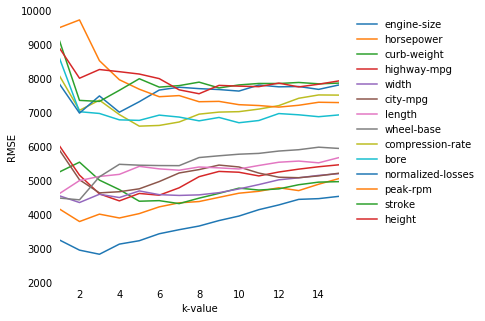

In [9]:
xlim = [1,15]
ylim = [2000, 10000]
fig, ax = plt.subplots(figsize=(5,5))

ax.set_ylabel("RMSE"), ax.set_xlabel("k-value")
ax.set_xlim(xlim), ax.set_ylim(ylim)


features = sorted_features
k_value = np.arange(1,20)

#run the model
for element_x in features:
    rmse = []
    for element_y in k_value:
        rmse.append(knn_train_test([element_x], ['price'], element_y, numeric_cars))
    
    #plot results
    ax.plot(k_value, rmse, label=element_x)
   
ax.tick_params(left=False, right=False, top=False, bottom=False)    
for key,spine in ax.spines.items():
        spine.set_visible(False)    

ax.legend(loc=[1.05,0.2], frameon=False)
plt.show()

- Independently of the value of k there are some variables which clearly hold lower RMSE values
- Of those engine-size and horsepower are the best two

**Combined features (only the three best combinations from before)**

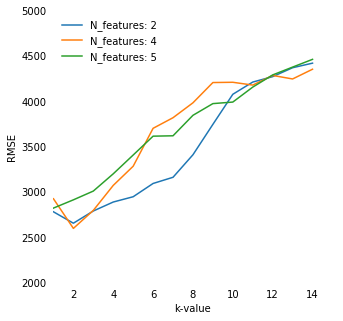

In [10]:
xlim = [1,15]
ylim = [2000, 5000]

fig, ax = plt.subplots(figsize=(5,5))
ax.set_ylabel("RMSE"), ax.set_xlabel("k-value")
ax.set_xlim(xlim), ax.set_ylim(ylim)


features = [['engine-size', 'horsepower'],
            ['engine-size', 'horsepower', 'curb-weight', 'highway-mpg'],
            ['engine-size', 'horsepower', 'curb-weight', 'highway-mpg', 'width']]

k_value = np.arange(1,15)

#run the model
for element_x in features:
    rmse = []
    std_rmse = []
    for element_y in k_value:
        rmse.append(knn_train_test(element_x, ['price'], element_y, numeric_cars))
     
    #plot results
    ax.plot(k_value, rmse, label="N_features: {:d}".format(len(element_x)))
    
ax.tick_params(left=False, right=False, top=False, bottom=False)    
for key,spine in ax.spines.items():
        spine.set_visible(False) 

ax.legend(loc='best', frameon=False)
plt.show()

The best model is actually the one with 4 features and k=2 (before we got the best model being the one with 2 features because we were just looking at k=5)

<br>

## 3 - K-fold Validation
- using k=2 or 5 for the knn model
- k_folds = np.arange(5,200, 20)
- look at the 2 best models (2 and 4 features)

In [21]:
def knn_train_test(feature, target, fold, df, k_neighbors=5):
    kf = KFold(fold, shuffle=True, random_state=1)
    model = KNeighborsRegressor(n_neighbors = k_neighbors, algorithm = 'auto', p=2)
    mses = cross_val_score(model, df[feature], df[target], scoring="neg_mean_squared_error", cv=kf)
    rmses = np.sqrt(np.absolute(mses))
    return(np.mean(rmses), np.std(rmses))
  
features = [['engine-size', 'horsepower'],
            ['engine-size', 'horsepower', 'curb-weight', 'highway-mpg']]
k_folds = np.arange(5,200, 20)

k = 2

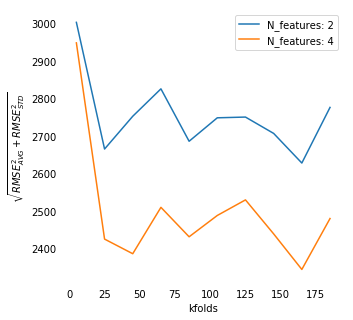

In [22]:
fig, ax = plt.subplots(figsize=(5,5))

#run the model
for element_x in features:
    rmse_mean_list = []
    rmse_std_list = []
    for element_y in k_folds:
        (rmse_mean, rmse_std) = knn_train_test(element_x, ['price'], element_y, numeric_cars, k_neighbors=2)
        rmse_mean_list.append(rmse_mean)
        rmse_std_list.append(rmse_std)   
    ax.plot(k_folds, np.sqrt(np.array(rmse_mean_list)**2+np.array(rmse_std_list)**2), 
            label="N_features: {:d}".format(len(element_x)))
   
ax.tick_params(left=False, right=False, top=False, bottom=False)       
for key,spine in ax.spines.items():
        spine.set_visible(False) 
ax.set_ylabel("$\sqrt{RMSE_{AVG}^2+RMSE_{STD}^2}$"), ax.set_xlabel("kfolds")

ax.legend()
plt.show()

k = 5

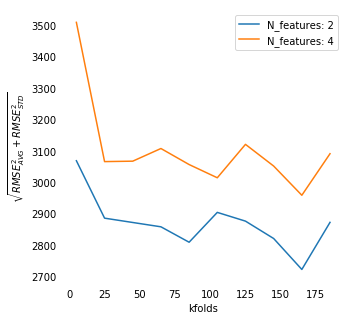

In [23]:
fig, ax = plt.subplots(figsize=(5,5))

#run the model
for element_x in features:
    rmse_mean_list = []
    rmse_std_list = []
    for element_y in k_folds:
        (rmse_mean, rmse_std) = knn_train_test(element_x, ['price'], element_y, numeric_cars, k_neighbors=5)
        rmse_mean_list.append(rmse_mean)
        rmse_std_list.append(rmse_std)   
    ax.plot(k_folds, np.sqrt(np.array(rmse_mean_list)**2+np.array(rmse_std_list)**2), 
            label="N_features: {:d}".format(len(element_x)))
   
ax.tick_params(left=False, right=False, top=False, bottom=False)       
for key,spine in ax.spines.items():
        spine.set_visible(False) 
ax.set_ylabel("$\sqrt{RMSE_{AVG}^2+RMSE_{STD}^2}$"), ax.set_xlabel("kfolds")

ax.legend()
plt.show()

Indeed k_neighbours=2 and 4 features seems to give the best results

## 4 - Predict for best model KNN model

In [60]:
features = ['engine-size', 'horsepower', 'curb-weight', 'highway-mpg']

kf = KFold(10, shuffle=True, random_state=1)
model = KNeighborsRegressor(n_neighbors = 2, algorithm = 'auto', p=2)
predictions = cross_val_predict(model, numeric_cars[features], numeric_cars['price'], cv=kf)

print(predictions[:5])
print(numeric_cars['price'][:5].values)

[8948.5 6812.  9870.  7212.  9044. ]
[ 9549.  6229. 10245.  7295.  9989.]


<br>

## 5 - Try LinearRegression and RandomForestRegressor models

In [50]:
def model_train_test(feature, target, fold, df, model):
    kf = KFold(fold, shuffle=True, random_state=1)   
    mses = cross_val_score(model, df[feature], df[target].values.ravel(), scoring="neg_mean_squared_error", 
                           cv=kf, error_score='raise')
    rmses = np.sqrt(np.absolute(mses))
    return(np.mean(rmses), np.std(rmses))

<br>

### LinearRegression with RFECV feature selection and k-fold validation

In [32]:
def select_features(df, k_neighbors=2):    
    #select numeric and drop NaNs
    df_new = df.select_dtypes([np.number]).dropna(axis=1)
    
    all_X = df_new.drop(['price'],axis=1)
    all_y = df_new['price']
    
    model = LinearRegression()
    #cv is the number of folds
    selector = RFECV(model, cv=10)
    selector.fit(all_X, all_y)    
    optimized_columns = list(all_X.columns[selector.support_])
    
    print("Best Columns \n"+"-"*12+"\n{}\n".format(optimized_columns))
    
    return optimized_columns

optimized_columns = select_features(numeric_cars, k_neighbors=2)

Best Columns 
------------
['wheel-base', 'length', 'width', 'curb-weight', 'engine-size', 'stroke', 'compression-rate', 'horsepower', 'peak-rpm', 'city-mpg', 'highway-mpg']



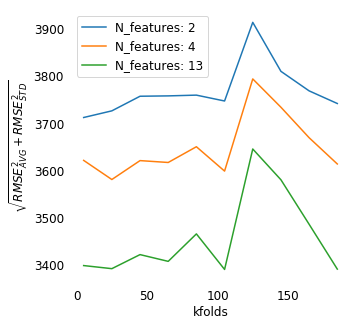

In [52]:
k_folds = np.arange(5,200, 20)
model = LinearRegression()

fig, ax = plt.subplots(figsize=(5,5))

features = [['engine-size', 'horsepower'],
            ['engine-size', 'horsepower', 'curb-weight', 'highway-mpg'],
            optimized_columns]

#run the model
for element_x in features:
    rmse_mean_list = []
    rmse_std_list = []
    for element_y in k_folds:
        (rmse_mean, rmse_std) = model_train_test(element_x, ['price'], element_y, numeric_cars, model)
        rmse_mean_list.append(rmse_mean)
        rmse_std_list.append(rmse_std)   
    ax.plot(k_folds, np.sqrt(np.array(rmse_mean_list)**2+np.array(rmse_std_list)**2), 
            label="N_features: {:d}".format(len(element_x)))
   
ax.tick_params(left=False, right=False, top=False, bottom=False)       
for key,spine in ax.spines.items():
        spine.set_visible(False) 
ax.set_ylabel("$\sqrt{RMSE_{AVG}^2+RMSE_{STD}^2}$"), ax.set_xlabel("kfolds")

ax.legend()
plt.show()

the best combination of features for LinearRegression still gives an error of ~3400, compared to ~2500 for the best KNN model

<br>

### RandomForestRegressor with RFECV feature selection and k-fold validation

In [46]:
def select_features(df, k_neighbors=2):    
    #select numeric and drop NaNs
    df_new = df.select_dtypes([np.number]).dropna(axis=1)
    
    all_X = df_new.drop(['price'],axis=1)
    all_y = df_new['price']
    
    model = RandomForestRegressor(n_estimators=100, random_state=1, min_samples_leaf=2)
    #cv is the number of folds
    selector = RFECV(model, cv=10)
    selector.fit(all_X, all_y)    
    optimized_columns = list(all_X.columns[selector.support_])
    
    print("Best Columns \n"+"-"*12+"\n{}\n".format(optimized_columns))
    
    return optimized_columns

optimized_columns = select_features(numeric_cars, k_neighbors=2)

Best Columns 
------------
['normalized-losses', 'wheel-base', 'length', 'width', 'height', 'curb-weight', 'engine-size', 'stroke', 'compression-rate', 'horsepower', 'peak-rpm', 'city-mpg', 'highway-mpg']



Doing 1 of 3 features combinations
Doing 2 of 3 features combinations
Doing 3 of 3 features combinations


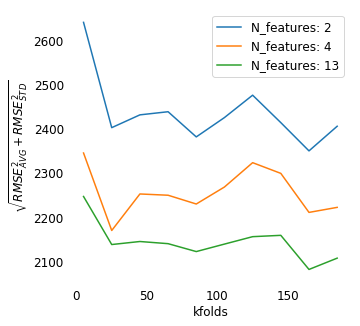

In [55]:
k_folds = np.arange(5,200, 20)
model = RandomForestRegressor(n_estimators=100, random_state=1, min_samples_leaf=2)

fig, ax = plt.subplots(figsize=(5,5))

features = [['engine-size', 'horsepower'],
            ['engine-size', 'horsepower', 'curb-weight', 'highway-mpg'],
            optimized_columns]

#run the model
for idx, element_x in enumerate(features):
    print("Doing {:d} of {:d} features combinations".format(idx+1, len(features)))
    rmse_mean_list = []
    rmse_std_list = []
    for element_y in k_folds:
        (rmse_mean, rmse_std) = model_train_test(element_x, ['price'], element_y, numeric_cars, model)
        rmse_mean_list.append(rmse_mean)
        rmse_std_list.append(rmse_std)   
    ax.plot(k_folds, np.sqrt(np.array(rmse_mean_list)**2+np.array(rmse_std_list)**2), 
            label="N_features: {:d}".format(len(element_x)))
   
ax.tick_params(left=False, right=False, top=False, bottom=False)       
for key,spine in ax.spines.items():
        spine.set_visible(False) 
ax.set_ylabel("$\sqrt{RMSE_{AVG}^2+RMSE_{STD}^2}$"), ax.set_xlabel("kfolds")

ax.legend()
plt.show()

RandomForestRegressor gives the best result, with ~2100, compared to ~2500 for the best KNN model

**Predict for RandomForestRegressor**

In [62]:
kf = KFold(20, shuffle=True, random_state=1)
model = RandomForestRegressor(n_estimators=100, random_state=1, min_samples_leaf=2)
predictions = cross_val_predict(model, numeric_cars[optimized_columns], numeric_cars['price'], cv=kf)

print(predictions[:5])
print(numeric_cars['price'][:5].values)

[ 9092.15883333  6607.4000119   9323.62714286  6978.54160317
 10305.75547619]
[ 9549.  6229. 10245.  7295.  9989.]
